# HEOM 1d: Spin-Bath model, fitting of spectrum and correlation functions

## Introduction

The HEOM method solves the dynamics and steady state of a system and its environment, the latter of which is encoded 
in a set of auxiliary density matrices.

In this example we show the evolution of a single two-level system in contact with a single bosonic environment.

The properties of the system are encoded in Hamiltonian, and a coupling operator which describes how it is coupled to the environment.

The bosonic environment is implicitly assumed to obey a particular Hamiltonian ([see paper](https://arxiv.org/abs/2010.10806)), the parameters of which are encoded in the spectral density, and subsequently the free-bath correlation functions.

In the example below we show how to model an Ohmic environment with exponential cut-off in three ways:

* First we fit the spectral density with a set of underdamped brownian oscillator functions.
* Second, we evaluate the correlation functions, and fit those with a certain choice of exponential functions.
* Third, we use the available OhmicBath class 

In each case we will use the fit parameters to determine the correlation function expansion co-efficients needed to construct a description of the bath (i.e. a `BosonicBath` object) to supply to the `HEOMSolver` so that we can solve for the system dynamics.

## Setup

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import qutip
from qutip import (
    basis,
    expect,
    sigmax,
    sigmaz,
)
from qutip.solver.heom import (
    HEOMSolver
)
from qutip.core.environment import BosonicEnvironment,OhmicEnvironment

# Import mpmath functions for evaluation of gamma and zeta
# functions in the expression for the correlation:

from mpmath import mp

mp.dps = 15
mp.pretty = True

%matplotlib inline

## System and bath definition

Let us set up the system Hamiltonian, bath and system measurement operators:

### System Hamiltonian

In [2]:
# Defining the system Hamiltonian
eps = 0  # Energy of the 2-level system.
Del = 0.2  # Tunnelling term
Hsys = 0.5 * eps * sigmaz() + 0.5 * Del * sigmax()
rho0 = basis(2, 0) * basis(2, 0).dag()

### System measurement operators

In [3]:
# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p = basis(2, 0) * basis(2, 0).dag()
P22p = basis(2, 1) * basis(2, 1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p = basis(2, 0) * basis(2, 1).dag()

### Bath and HEOM parameters

Finally, let's set the bath parameters we will work with and write down some measurement operators:

In [4]:
Q = sigmaz()
alpha = 3.25
T = 0.5
wc = 1.0
s = 1

And set the cut-off for the HEOM hierarchy:

In [ ]:
# HEOM parameters:

# The max_depth defaults to 5 so that the notebook executes more
# quickly. Change it to 11 to wait longer for more accurate results.
max_depth = 5 #could not do 11 my laptop rans out of ram
# I used 7 because I wanted to make sure things were working correctly
# cf is terribly slow at 7, probably can be done better by changing guess, lower
# upper, use 5 to play around :)

# options used for the differential equation solver, while default works it 
# is way slower than using bdf
options = {
    "nsteps":15000, "store_states":True, "rtol":1e-12, "atol":1e-12, "method":"bdf",
}

#### Plotting function

In [6]:
def plot_result_expectations(plots, axes=None):
    """Plot the expectation values of operators as functions of time.

    Each plot in plots consists of (solver_result,
    measurement_operation, color, label).
    """
    if axes is None:
        fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 8))
        fig_created = True
    else:
        fig = None
        fig_created = False

    # add kw arguments to each plot if missing
    plots = [p if len(p) == 5 else p + ({},) for p in plots]
    for result, m_op, color, label, kw in plots:
        exp = np.real(expect(result.states, m_op))
        kw.setdefault("linewidth", 2)
        if color == "rand":
            axes.plot(
                result.times,
                exp,
                c=np.random.rand(
                    3,
                ),
                label=label,
                **kw,
            )
        else:
            axes.plot(result.times, exp, color, label=label, **kw)

    if fig_created:
        axes.legend(loc=0, fontsize=12)
        axes.set_xlabel("t", fontsize=28)

    return fig

# Obtaining a decaying Exponential description of the environment

In order to carry out our HEOM simulation, we need to express the correlation 
function as a sum of decaying exponentials, that is we need to express it as 

$$C(\tau)= \sum_{k=0}^{N-1}c_{k}e^{-\nu_{k}t}$$

As the correlation function of the environment is tied to it's power spectrum via 
a Fourier transform, such a representation of the correlation function implies a 
power spectrum of the form

$$S(\omega)= \sum_{k}2 Re\left( \frac{c_{k}}{\nu_{k}- i \omega}\right)$$

There are several ways one can obtain such a decomposition, in this tutorial we 
will cover the following approaches:

- Non-Linear Least Squares:
    - On the Spectral Density (`sd`)
    - On the Correlation Function (`cf`)
    - On the Power Spectrum (`ps`)
- Methods based on the Prony Polynomial
    - Prony on the correlation function(`prony`)
    - The Matrix Pencil method on the correlation function (`mp`) :question:
    - ESPRIT on the correlation function(`esprit`)
- Methods based on rational Approximations
    - The AAA algorithm on the Power Spectrum (`aaa`)
    - ESPIRA-I (`espira-I`) :question:
    - ESPIRA-II (`espira-II`)

the ones with a question mark are the ones I think maybe can be deleted.
Here's a quick high level comparison between the three different families 
of methods


<table>
  <tr>
    <th>Class</th>
    <th>Requires Extra information</th>
    <th>Fast</th>
    <th>Resilient to Noise</th>
    <th>Allows constraitns</th>
    <th>Stable</th>

    
  </tr>
  <tr>
    <td align="center"> Non-Linear Least Squares</td>
    <td align="center">✔️</td>
    <td align="center">❌</td>
    <td align="center">❌</td>
    <td align="center">✔️</td>
    <td align="center">❌</td>
  </tr>
  <tr>
    <td align="center">Prony Polynomial</td>
    <td align="center">❌</td>
    <td align="center">✔️</td>
    <td align="center">❗</td>
    <td align="center">❌</td>
    <td align="center">❗</td>
  </tr>
  <tr>
    <td align="center">Rational Approximations </td>
    <td align="center">❌</td>
    <td align="center">✔️</td>
    <td align="center">❗</td>
    <td align="center">❗</td>
    <td align="center">✔️</td>
  </tr>
</table>

Legend:

❌: NO ✔️: Yes ❗: Partially

# Non-Linear Least Squares

In [7]:
obs = OhmicEnvironment(T, alpha, wc,s=1)
tlist = np.linspace(0, 30 * np.pi / Del, 600)

## Correlation Function

In [8]:
t=np.linspace(0,20,500)
Obath, fitinfo = obs.approximate(method="cf",tlist=t,Nr_max=4,Ni_max=4,maxfev=1e9,target_rsme=None)
print(fitinfo["summary"])
HEOM_ohmic_corr_fit = HEOMSolver(
    Hsys,
    (Obath,Q),
    max_depth=max_depth,
    options=options,
)
results_ohmic_corr_fit = HEOM_ohmic_corr_fit.run(rho0, tlist)

Correlation function fit:

Result of fitting the real part of                                    |Result of fitting the imaginary part                                   
the correlation function with 4 terms:                                |of the correlation function with 4 terms:                              
                                                                      |                                                                       
 Parameters|    a     |    b     |    c                               | Parameters|    a     |    b     |    c                                
 1         |-1.98e+00 |-4.66e+00 |2.58e+00                            | 1         |-1.34e+01 |-1.05e+00 |2.56e-02                             
 2         | 3.89e-02 |-1.43e-01 |5.74e-32                            | 2         |-8.73e+00 |-3.57e-01 |8.36e-04                             
 3         | 3.45e-01 |-5.95e-01 |1.62e-06                            | 3         | 5.48e-01 |-4.30e+00 |3.99e+00  

## Spectral Density

In [9]:
w=np.linspace(0,30,500)
Obath2, fitinfo = obs.approximate(method="sd",wlist=w,Nmax=4,Nk=3)
print(fitinfo["summary"])
HEOM_ohmic_sd_fit = HEOMSolver(
    Hsys,
    (Obath2,Q),
    max_depth=max_depth,
    options=options,
)
results_ohmic_sd_fit = HEOM_ohmic_sd_fit.run(rho0, tlist)

Result of fitting the spectral density with 4 terms: 
 
 Parameters|    a     |    b     |    c 
 1         | 1.06e-02 | 3.06e-01 |1.02e-01
 2         |-4.41e+00 | 4.30e+00 |3.98e+00
 3         | 6.01e-01 | 1.00e+00 |1.02e-01
 4         | 7.92e+00 | 2.30e+00 |1.02e-01
 
A 1-R2 coefficient of  1.30e-06 was obtained for the the spectral density.
The current fit took  0.340964 seconds.
10.0%. Run time:   6.95s. Est. time left: 00:00:01:02
20.0%. Run time:  11.80s. Est. time left: 00:00:00:47
30.1%. Run time:  16.72s. Est. time left: 00:00:00:38
40.1%. Run time:  21.69s. Est. time left: 00:00:00:32
50.1%. Run time:  26.73s. Est. time left: 00:00:00:26
60.1%. Run time:  31.86s. Est. time left: 00:00:00:21
70.1%. Run time:  37.40s. Est. time left: 00:00:00:15
80.1%. Run time:  43.64s. Est. time left: 00:00:00:10
90.2%. Run time:  49.99s. Est. time left: 00:00:00:05
100.0%. Run time:  56.89s. Est. time left: 00:00:00:00
Total run time:  56.89s


## Power Spectrum

In [10]:
w=np.linspace(-50,30,500)
Obath3, fitinfo = obs.approximate(method="ps",wlist=w,Nmax=5)
print(fitinfo["summary"])
HEOM_ohmic_ps_fit = HEOMSolver(
    Hsys,
    (Obath3,Q),
    max_depth=max_depth,
    options=options,
)
results_ohmic_ps_fit = HEOM_ohmic_ps_fit.run(rho0, tlist)

Result of fitting the power spectrum with 5 terms: 
 
 Parameters|    a     |    b     |    c     |    d 
 1         | 4.87e+00 |-4.87e+00 | 6.25e-01 |-5.50e-02
 2         | 6.51e-01 | 4.82e+00 | 5.00e-01 |1.87e-02
 3         |-4.87e+00 |-9.32e-01 | 5.00e-01 |-9.85e-02
 4         | 1.50e+00 | 7.36e-01 | 2.45e+00 |1.41e+00
 5         |-6.40e-01 | 2.47e-01 | 3.98e+00 |3.14e+00
 
A 1-R2 coefficient of  1.08e-04 was obtained for the the power spectrum.
The current fit took  3.187300 seconds.
10.0%. Run time:   3.44s. Est. time left: 00:00:00:30
20.0%. Run time:   5.72s. Est. time left: 00:00:00:22
30.1%. Run time:   8.00s. Est. time left: 00:00:00:18
40.1%. Run time:  10.33s. Est. time left: 00:00:00:15
50.1%. Run time:  12.61s. Est. time left: 00:00:00:12
60.1%. Run time:  14.88s. Est. time left: 00:00:00:09
70.1%. Run time:  16.46s. Est. time left: 00:00:00:07
80.1%. Run time:  17.92s. Est. time left: 00:00:00:04
90.2%. Run time:  19.40s. Est. time left: 00:00:00:02
100.0%. Run time:  20

# Methods based on the Prony Polinomial

## Prony

In [11]:
tlist2=np.linspace(0,40,100)
pbath,fitinfo=obs.approximate("prony",tlist2,Nr=4)
print(fitinfo["summary"])
HEOM_ohmic_prony_fit = HEOMSolver(
    Hsys,
    (pbath,Q),
    max_depth=max_depth,
    options=options,
)
results_ohmic_prony_fit = HEOM_ohmic_prony_fit.run(rho0, tlist)

Result of fitting Correlation Function with 4 terms: 
 
 Parameters|    a     |    b     |    c     |    d 
 1         | 4.97e-02 |-2.48e-02 |-4.97e-02 |-2.48e-02
 2         | 2.38e-01 |-5.58e-01 |-2.38e-01 |-5.58e-01
 3         | 7.39e-01 | 4.93e-01 |-7.39e-01 |4.93e-01
 4         |-2.67e-01 | 8.95e-02 | 2.67e-01 |8.95e-02
 
A 1-R2 coefficient of  3.09e-05+9.93e-06j was obtained for the Correlation Function.
The current fit took  0.170541 seconds.
10.0%. Run time:   0.92s. Est. time left: 00:00:00:08
20.0%. Run time:   1.51s. Est. time left: 00:00:00:06
30.1%. Run time:   2.10s. Est. time left: 00:00:00:04
40.1%. Run time:   2.68s. Est. time left: 00:00:00:04
50.1%. Run time:   3.23s. Est. time left: 00:00:00:03
60.1%. Run time:   3.79s. Est. time left: 00:00:00:02
70.1%. Run time:   4.37s. Est. time left: 00:00:00:01
80.1%. Run time:   4.94s. Est. time left: 00:00:00:01
90.2%. Run time:   5.53s. Est. time left: 00:00:00:00
100.0%. Run time:   6.09s. Est. time left: 00:00:00:00
Total 

## Matrix Pencil

In [12]:
mpbath,fitinfo=obs.approximate(method="mp",tlist=tlist2,Nr=5,Ni=5,separate=True)
print(fitinfo["summary"])
HEOM_ohmic_mp_fit = HEOMSolver(
    Hsys,
    (mpbath,Q),
    max_depth=max_depth,
    options=options,
)
results_ohmic_mp_fit = HEOM_ohmic_mp_fit.run(rho0, tlist)

Correlation function fit:

Result of fitting the real part of                                              |Result of fitting the imaginary part                                             
the correlation function with 5 terms:                                          |of the correlation function with 5 terms:                                        
                                                                                |                                                                                 
 Parameters|    a     |    b     |    c     |    d                              | Parameters|    a     |    b     |    c     |    d                               
 1         | 1.94e+00 | 8.61e+00 |-0.00e+00 |0.00e+00                           | 1         | 9.91e-17 |-6.25e-01 |-7.78e+00 |0.00e+00                            
 2         |-1.37e+01 | 4.65e+00 |-0.00e+00 |0.00e+00                           | 2         | 1.07e+00 | 4.39e+00 |-1.75e+00 |-1.46e+00                       

## ESPRIT

In [13]:
esbath,fitinfo=obs.approximate("esprit",tlist2,Nr=4)
print(fitinfo["summary"])
HEOM_ohmic_es_fit = HEOMSolver(
    Hsys,
    (esbath,Q),
    max_depth=max_depth,
    options=options,
)
results_ohmic_es_fit = HEOM_ohmic_es_fit.run(rho0, tlist)

Result of fitting Correlation Function with 4 terms: 
 
 Parameters|    a     |    b     |    c     |    d 
 1         |-2.67e-01 | 8.95e-02 | 2.67e-01 |8.95e-02
 2         | 7.39e-01 | 4.93e-01 |-7.39e-01 |4.93e-01
 3         | 2.38e-01 |-5.58e-01 |-2.38e-01 |-5.58e-01
 4         | 4.97e-02 |-2.48e-02 |-4.97e-02 |-2.48e-02
 
A 1-R2 coefficient of  3.09e-05+9.93e-06j was obtained for the Correlation Function.
The current fit took  0.167535 seconds.
10.0%. Run time:   0.93s. Est. time left: 00:00:00:08
20.0%. Run time:   1.54s. Est. time left: 00:00:00:06
30.1%. Run time:   2.16s. Est. time left: 00:00:00:05
40.1%. Run time:   2.77s. Est. time left: 00:00:00:04
50.1%. Run time:   3.35s. Est. time left: 00:00:00:03
60.1%. Run time:   3.92s. Est. time left: 00:00:00:02
70.1%. Run time:   4.48s. Est. time left: 00:00:00:01
80.1%. Run time:   5.08s. Est. time left: 00:00:00:01
90.2%. Run time:   5.66s. Est. time left: 00:00:00:00
100.0%. Run time:   6.21s. Est. time left: 00:00:00:00
Total 

# Rational Approximations

## AAA

In [14]:
aaabath,fitinfo=obs.approximate("aaa",np.concatenate((-np.logspace(3,-8,3500),np.logspace(-8,3,3500))),N_max=6,tol=1e-15)
print(fitinfo["summary"])
HEOM_ohmic_aaa_fit = HEOMSolver(
    Hsys,
    (aaabath,Q),
    max_depth=max_depth,
    options=options,
)
results_ohmic_aaa_fit = HEOM_ohmic_aaa_fit.run(rho0, tlist)

/home/gerardo/Documents/gsuarezr/qutip_gsoc_app/qutip/utilities.py:55: RuntimeWarning: overflow encountered in exp
  result[non_zero] = 1 / (np.exp(w[non_zero] / w_th) - 1)


Result of fitting the power spectrum with 5 terms: 
 
 Parameters|    a     |    b     |    c     |    d 
 1         | 9.81e-01 | 1.27e+00 | 2.27e+00 |1.79e+00
 2         | 5.53e-01 |-1.05e+00 | 9.41e-01 |-1.62e-01
 3         | 3.92e-02 |-3.15e-02 | 1.52e-01 |-3.28e-02
 4         | 4.13e-04 |-1.91e-04 | 1.13e-02 |-1.67e-03
 5         | 4.66e-08 |-2.57e-07 | 1.38e-04 |-1.27e-04
 
A 1-R2 coefficient of  1.09e-04 was obtained for the the power spectrum.
The current fit took  10.199787 seconds.
10.0%. Run time:   1.56s. Est. time left: 00:00:00:14
20.0%. Run time:   2.42s. Est. time left: 00:00:00:09
30.1%. Run time:   3.26s. Est. time left: 00:00:00:07
40.1%. Run time:   4.11s. Est. time left: 00:00:00:06
50.1%. Run time:   4.95s. Est. time left: 00:00:00:04
60.1%. Run time:   5.80s. Est. time left: 00:00:00:03
70.1%. Run time:   6.64s. Est. time left: 00:00:00:02
80.1%. Run time:   7.49s. Est. time left: 00:00:00:01
90.2%. Run time:   8.33s. Est. time left: 00:00:00:00
100.0%. Run time: 

# ESPIRA I

In [15]:
tlist4=np.linspace(0,20,1000)
espibath,fitinfo=obs._approx_by_prony("espira-I",tlist4,Nr=4,Ni=4,separate=True)
print(fitinfo["summary"])
HEOM_ohmic_espira_fit = HEOMSolver(
    Hsys,
    (espibath,Q),
    max_depth=max_depth,
    options=options,
)
results_ohmic_espira_fit = HEOM_ohmic_espira_fit.run(rho0, tlist)

Correlation function fit:

Result of fitting the real part of                                              |Result of fitting the imaginary part                                             
the correlation function with 4 terms:                                          |of the correlation function with 4 terms:                                        
                                                                                |                                                                                 
 Parameters|    a     |    b     |    c     |    d                              | Parameters|    a     |    b     |    c     |    d                               
 1         | 2.18e-01 | 3.22e+00 | 1.52e+00 |1.58e+00                           | 1         | 7.39e-01 | 3.68e+00 |-2.44e+00 |-5.14e-01                           
 2         | 8.01e-01 | 2.84e+00 |-1.32e+00 |-1.54e+00                          | 2         | 9.27e-01 | 3.57e+00 | 2.23e+00 |4.43e-01                        

# ESPIRA II

In [16]:
espibath2,fitinfo=obs._approx_by_prony("espira-II",tlist4,Nr=4,Ni=4,separate=True)
print(fitinfo["summary"])
HEOM_ohmic_espira_fit2 = HEOMSolver(
    Hsys,
    (espibath2,Q),
    max_depth=max_depth,
    options=options,
)
results_ohmic_espira2_fit = HEOM_ohmic_espira_fit2.run(rho0, tlist)

Correlation function fit:

Result of fitting the real part of                                              |Result of fitting the imaginary part                                             
the correlation function with 4 terms:                                          |of the correlation function with 4 terms:                                        
                                                                                |                                                                                 
 Parameters|    a     |    b     |    c     |    d                              | Parameters|    a     |    b     |    c     |    d                               
 1         | 3.75e-01 | 2.85e+00 |-1.66e+00 |-1.14e+00                          | 1         | 7.81e-01 | 3.59e+00 | 2.38e+00 |4.62e-01                            
 2         | 6.32e-01 | 2.62e+00 | 1.54e+00 |1.10e+00                           | 2         | 8.75e-01 | 3.51e+00 |-2.29e+00 |-4.10e-01                       

Finally we plot the dynamics obtained by the different methods

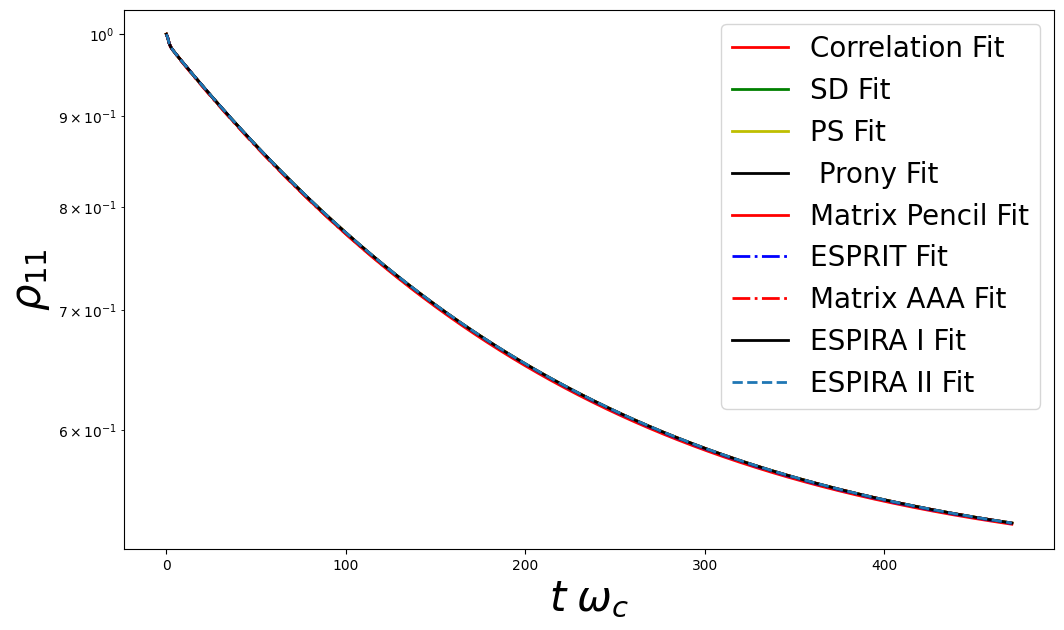

In [17]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(12, 7))

plot_result_expectations(
    [

        (results_ohmic_corr_fit, P11p, "r", "Correlation Fit"),
        (results_ohmic_sd_fit, P11p, "g", "SD Fit"),
        (results_ohmic_sd_fit, P11p, "y", "PS Fit"),
        (results_ohmic_prony_fit, P11p, "k", " Prony Fit"),
        (results_ohmic_mp_fit, P11p, "r", "Matrix Pencil Fit"),
        (results_ohmic_es_fit, P11p, "b-.", "ESPRIT Fit"),
        (results_ohmic_aaa_fit, P11p, "r-.", "Matrix AAA Fit"),
        (results_ohmic_espira_fit, P11p, "k", "ESPIRA I Fit"),
        (results_ohmic_espira2_fit, P11p, "--", "ESPIRA II Fit"),

    ],
    axes=axes,
)
axes.set_ylabel(r"$\rho_{11}$", fontsize=30)
axes.set_xlabel(r"$t\;\omega_c$", fontsize=30)
axes.legend(loc=0, fontsize=20);
axes.set_yscale("log")

## About

In [18]:
qutip.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.2.0.dev0+678a16d
Numpy Version:      2.2.1
Scipy Version:      1.15.0
Cython Version:     3.0.11
Matplotlib Version: 3.10.0
Python Version:     3.13.0
Number of CPUs:     8
BLAS Info:          Generic
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/gerardo/Documents/gsuarezr/qutip_gsoc_app/qutip

Installed QuTiP family packages
-------------------------------

No QuTiP family packages installed.

P

## Testing

This section can include some tests to verify that the expected outputs are generated within the notebook. We put this section at the end of the notebook, so it's not interfering with the user experience. Please, define the tests using assert, so that the cell execution fails if a wrong output is generated.

In [20]:
tol=1e-2
assert np.allclose(
    expect(P11p, results_ohmic_ps_fit.states),
    expect(P11p, results_ohmic_sd_fit.states),
    rtol=tol,
)
assert np.allclose(
    expect(P11p, results_ohmic_corr_fit.states),
    expect(P11p, results_ohmic_sd_fit.states),
    rtol=tol,
)
assert np.allclose(
    expect(P11p, results_ohmic_aaa_fit.states),
    expect(P11p, results_ohmic_sd_fit.states),
    rtol=tol,
)
assert np.allclose(
    expect(P11p, results_ohmic_mp_fit.states),
    expect(P11p, results_ohmic_sd_fit.states),
    rtol=tol,
)
assert np.allclose(
    expect(P11p, results_ohmic_prony_fit.states),
    expect(P11p, results_ohmic_sd_fit.states),
    rtol=tol,
)

assert np.allclose(
    expect(P11p, results_ohmic_es_fit.states),
    expect(P11p, results_ohmic_sd_fit.states),
    rtol=tol,
)
assert np.allclose(
    expect(P11p, results_ohmic_espira_fit.states),
    expect(P11p, results_ohmic_sd_fit.states),
    rtol=tol,
)
assert np.allclose(
    expect(P11p, results_ohmic_espira2_fit.states),
    expect(P11p, results_ohmic_sd_fit.states),
    rtol=tol,
)